# Modelling Notebook

## Modelling Dashboard

Uses Cleaned Preprocessed Data Without Sensitive Information. <br/>
Preprocessing of Sensitive Data Is Handled Separately.

In [1]:
# General
import random
random.seed(42)
import pickle
import numpy as np
import pandas as pd
from scipy.stats import randint

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# Evaluation Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Warnings
import warnings
warnings.filterwarnings('ignore')

### Regression Metrics

1. **Mean Absolute Error (MAE)**
   - Formula: $ \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i| $
   - Description: The average of the absolute differences between the predicted values and actual values. It gives an idea of how wrong the predictions were.
   

2. **Mean Absolute Percentage Error (MAPE)**
   - Formula: $ \text{MAPE} = \frac{100}{n} \sum_{i=1}^{n} |\frac{y_i - \hat{y}_i}{y_i}| $
   - Description: Provides an intuitive understanding of model's predictive accuracy relative to actual values. It measures the absolute percentage difference between the predicted values and the actual values.


3. **Mean Squared Error (MSE)**
   - Formula: $ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $
   - Description: The average of the squared differences between the predicted values and actual values. It penalizes larger errors more than MAE.


4. **Root Mean Squared Error (RMSE)**
   - Formula: $ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $
   - Description: The square root of the average of the squared differences between the predicted values and actual values. It is in the same units as the response variable and is sensitive to outliers.


5. **R-squared (Coefficient of Determination)**
   - Formula: $ R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2} $
   - Description: The proportion of the variance in the dependent variable that is predictable from the independent variables. It provides a measure of how well observed outcomes are replicated by the model.



### Modelling Job Duration Prediction

#### Import Dataset

In [2]:
# Read Dataset
aa_job_duration_df = pd.read_csv('./datasets/aa_job_duration.csv')

In [3]:
# Understanding Data I
aa_job_duration_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7592 entries, 0 to 7591
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   category   7592 non-null   object
 1   date       7592 non-null   object
 2   delay      7592 non-null   int64 
 3   duration   7592 non-null   int64 
 4   equipment  7592 non-null   object
 5   id         7592 non-null   int64 
 6   items      7592 non-null   int64 
 7   service    7592 non-null   object
 8   staff      7592 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 533.9+ KB


In [4]:
# Split Training & Testing Dataset
# Dependent Variable
target_list = ['duration']

# Independent Variables
feature_list = ['id', 'date', 'delay', 'category', 'equipment', 'items', 'service', 'staff']
print(feature_list)

# Selecting Target Variable and Features from Dataset
X = aa_job_duration_df[feature_list]
y = aa_job_duration_df[target_list]

['id', 'date', 'delay', 'category', 'equipment', 'items', 'service', 'staff']


In [5]:
# Split Training & Testing Dataset (80:20 Split)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6073, 8) (1519, 8) (6073, 1) (1519, 1)


In [6]:
# Reset Indexes
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

#### Data Preprocesing

In [7]:
# Check Missing Data
X_train.isnull().sum()[X_train.isnull().sum() > 0]
X_test.isnull().sum()[X_test.isnull().sum() > 0]

Series([], dtype: int64)

In [8]:
X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6073 entries, 0 to 6072
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         6073 non-null   int64 
 1   date       6073 non-null   object
 2   delay      6073 non-null   int64 
 3   category   6073 non-null   object
 4   equipment  6073 non-null   object
 5   items      6073 non-null   int64 
 6   service    6073 non-null   object
 7   staff      6073 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 379.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1519 entries, 0 to 1518
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1519 non-null   int64 
 1   date       1519 non-null   object
 2   delay      1519 non-null   int64 
 3   category   1519 non-null   object
 4   equipment  1519 non-null   object
 5   items      1519 non-null   int64 
 6   service    1519 non-null   ob

#### Feature Engineering

In [9]:
# Perform one-hot encoding for the 'category', 'equipment', and 'service' columns
X_train_one_hot_category = pd.get_dummies(X_train['category'], prefix='category')
X_train_one_hot_equipment = pd.get_dummies(X_train['equipment'], prefix='equipment')
X_train_one_hot_service = pd.get_dummies(X_train['service'], prefix='service')

# Concatenate the one-hot encoded DataFrames with the original DataFrame
X_train_encoded = pd.concat([X_train, X_train_one_hot_category, X_train_one_hot_equipment, X_train_one_hot_service], axis=1)

# Drop the original categorical columns if you no longer need them
X_train_encoded = X_train_encoded.drop(columns=['category', 'equipment', 'service'])

X_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6073 entries, 0 to 6072
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   id                         6073 non-null   int64 
 1   date                       6073 non-null   object
 2   delay                      6073 non-null   int64 
 3   items                      6073 non-null   int64 
 4   staff                      6073 non-null   int64 
 5   category_aircon            6073 non-null   bool  
 6   category_electrician       6073 non-null   bool  
 7   category_handyman          6073 non-null   bool  
 8   category_plumber           6073 non-null   bool  
 9   category_ventilation       6073 non-null   bool  
 10  equipment_basin            6073 non-null   bool  
 11  equipment_bidet            6073 non-null   bool  
 12  equipment_circuit-breaker  6073 non-null   bool  
 13  equipment_filter           6073 non-null   bool  
 14  equipmen

In [10]:
# Perform one-hot encoding for the 'category', 'equipment', and 'service' columns
X_test_one_hot_category = pd.get_dummies(X_test['category'], prefix='category')
X_test_one_hot_equipment = pd.get_dummies(X_test['equipment'], prefix='equipment')
X_test_one_hot_service = pd.get_dummies(X_test['service'], prefix='service')

# Concatenate the one-hot encoded DataFrames with the original DataFrame
X_test_encoded = pd.concat([X_test, X_test_one_hot_category, X_test_one_hot_equipment, X_test_one_hot_service], axis=1)

# Drop the original categorical columns if you no longer need them
X_test_encoded = X_test_encoded.drop(columns=['category', 'equipment', 'service'])

X_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1519 entries, 0 to 1518
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   id                         1519 non-null   int64 
 1   date                       1519 non-null   object
 2   delay                      1519 non-null   int64 
 3   items                      1519 non-null   int64 
 4   staff                      1519 non-null   int64 
 5   category_aircon            1519 non-null   bool  
 6   category_electrician       1519 non-null   bool  
 7   category_handyman          1519 non-null   bool  
 8   category_plumber           1519 non-null   bool  
 9   category_ventilation       1519 non-null   bool  
 10  equipment_basin            1519 non-null   bool  
 11  equipment_bidet            1519 non-null   bool  
 12  equipment_circuit-breaker  1519 non-null   bool  
 13  equipment_filter           1519 non-null   bool  
 14  equipmen

#### Feature Selection

In [11]:
# Keep Selected Features
X_train_selected = X_train_encoded.drop(columns=['date', 'delay', 'id'])
X_test_selected = X_test_encoded.drop(columns=['date', 'delay', 'id'])

print(X_train_selected.info())
print(X_test_selected.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6073 entries, 0 to 6072
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   items                      6073 non-null   int64
 1   staff                      6073 non-null   int64
 2   category_aircon            6073 non-null   bool 
 3   category_electrician       6073 non-null   bool 
 4   category_handyman          6073 non-null   bool 
 5   category_plumber           6073 non-null   bool 
 6   category_ventilation       6073 non-null   bool 
 7   equipment_basin            6073 non-null   bool 
 8   equipment_bidet            6073 non-null   bool 
 9   equipment_circuit-breaker  6073 non-null   bool 
 10  equipment_filter           6073 non-null   bool 
 11  equipment_general          6073 non-null   bool 
 12  equipment_inline           6073 non-null   bool 
 13  equipment_leak             6073 non-null   bool 
 14  equipment_light         

#### Machine Learning Modelling

In [12]:
# Evaluation 
def evaluate(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r_squared = r2_score(y_test, y_pred)
    
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R-squared Coefficient (R^2):", r_squared)

# Features Used
feature_names = X_train_selected.columns

##### Baseline Modelling

In [13]:
## Model Training
# Linear Regression
reg_lr = LinearRegression().fit(X_train_selected, y_train)
y_pred_lr = reg_lr.predict(X_test_selected)

evaluate(y_test, y_pred_lr)

Mean Absolute Error (MAE): 12.986041392363397
Mean Squared Error (MSE): 375.61222609318423
Root Mean Squared Error (RMSE): 19.380717894164402
R-squared Coefficient (R^2): 0.9473023204662383


In [14]:
# Decision Tree Regressor
reg_dtr = DecisionTreeRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_dtr = reg_dtr.predict(X_test_selected)

evaluate(y_test, y_pred_dtr)

Mean Absolute Error (MAE): 9.898818651846055
Mean Squared Error (MSE): 211.43639172009668
Root Mean Squared Error (RMSE): 14.540852510086768
R-squared Coefficient (R^2): 0.9703358771663723


<Axes: title={'center': 'Decision Tree Learning Curve (MAPE)'}, xlabel='Training examples', ylabel='Score'>

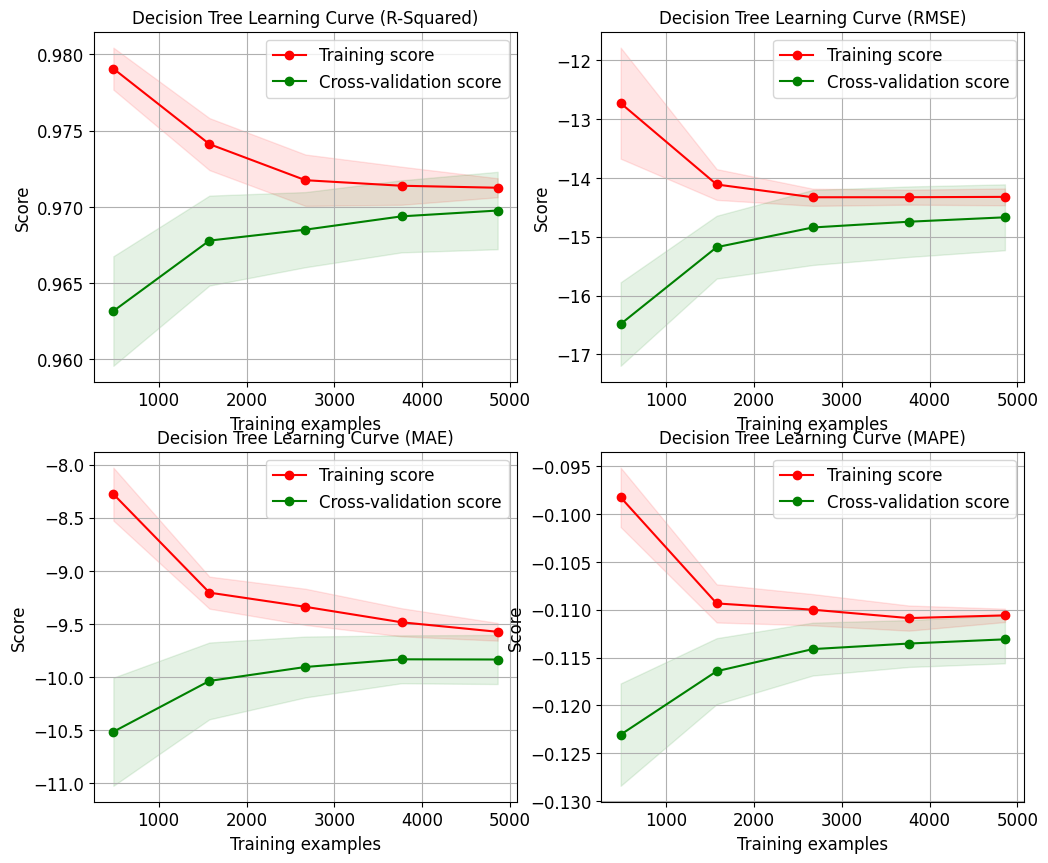

In [15]:
## Cross Validation
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  
ax1, ax2, ax3, ax4 = axes.flatten() 

# Learning curves
skplt.estimators.plot_learning_curve(DecisionTreeRegressor(random_state=42), X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="r2", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Decision Tree Learning Curve (R-Squared)", ax=ax1)
skplt.estimators.plot_learning_curve(DecisionTreeRegressor(random_state=42), X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="neg_root_mean_squared_error", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Decision Tree Learning Curve (RMSE)", ax=ax2)
skplt.estimators.plot_learning_curve(DecisionTreeRegressor(random_state=42), X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="neg_mean_absolute_error", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Decision Tree Learning Curve (MAE)", ax=ax3)
skplt.estimators.plot_learning_curve(DecisionTreeRegressor(random_state=42), X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="neg_mean_absolute_percentage_error", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Decision Tree Learning Curve (MAPE)", ax=ax4)

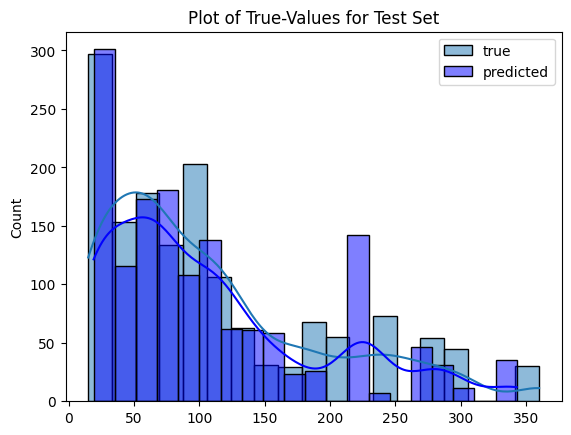

In [16]:
# Plot graph to visualise how far predictions are from true-values for test set
sns.histplot(y_test, label='true', color='red', kde=True)
sns.histplot(y_pred_dtr, label='predicted', color='blue', kde=True)
plt.title("Plot of True-Values for Test Set")
plt.legend()
plt.show()

In [17]:
# Decision Tree Model Parameters
reg_dtr.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [18]:
# Use RandomSearch 
param_dist = {
    "max_depth": randint(1, 20),  
    "min_samples_split": randint(2, 40),  
    "min_samples_leaf": randint(1, 20), 
    "max_features": [1.0, "sqrt", "log2", None],
}

rscv_dtr = RandomizedSearchCV(estimator = DecisionTreeRegressor(random_state=42), param_distributions = param_dist, n_iter = 100, scoring = 'neg_root_mean_squared_error', cv = 5, n_jobs = -1).fit(X_train_selected, y_train)

best_params_dtr = rscv_dtr.best_params_
print("Best Parameters For Decision Tree:", best_params_dtr)

y_pred_rscv_dtr = rscv_dtr.predict(X_test_selected)

evaluate(y_test, y_pred_rscv_dtr)

Best Parameters For Decision Tree: {'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 11, 'min_samples_split': 29}
Mean Absolute Error (MAE): 9.893611877000884
Mean Squared Error (MSE): 211.18698681575398
Root Mean Squared Error (RMSE): 14.532273972636009
R-squared Coefficient (R^2): 0.970370868199172


In [19]:
# Use Grid Search
params = { 
    'max_depth': [5, 10, 12, 15, 17, 20],     
    'min_samples_split': [2, 5, 10, 15, 20, 40], 
    'min_samples_leaf': [1, 3, 5, 7, 10, 20],
    "max_features": [1.0, None],
}

gscv_dtr = GridSearchCV(estimator = DecisionTreeRegressor(random_state=42), param_grid = params, scoring = 'neg_root_mean_squared_error', n_jobs = -1).fit(X_train_selected, y_train)

best_params_dtr = gscv_dtr.best_params_
print("Best Parameters For Decision Tree:", best_params_dtr)

y_pred_gscv_dtr = gscv_dtr.predict(X_test_selected)

evaluate(y_test, y_pred_gscv_dtr)

Best Parameters For Decision Tree: {'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 10, 'min_samples_split': 40}
Mean Absolute Error (MAE): 9.9039820882801
Mean Squared Error (MSE): 211.75343357536505
Root Mean Squared Error (RMSE): 14.55175018942275
R-squared Coefficient (R^2): 0.9702913967982504


<Axes: title={'center': 'Decision Tree Regressor with Hyperparameter Tuning Feature Importance'}>

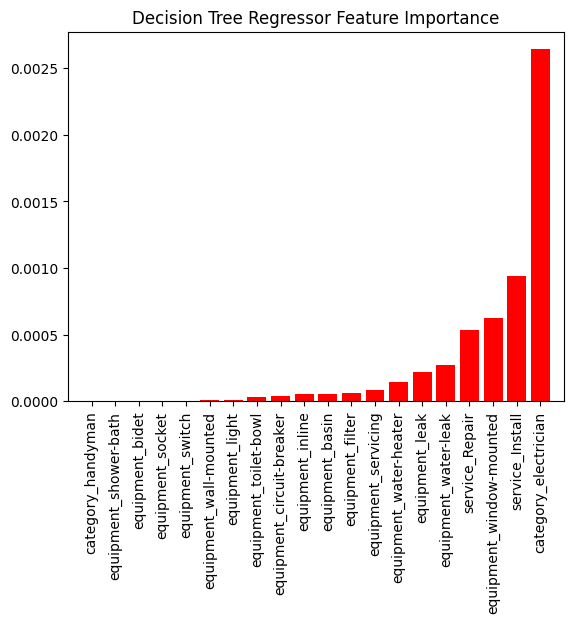

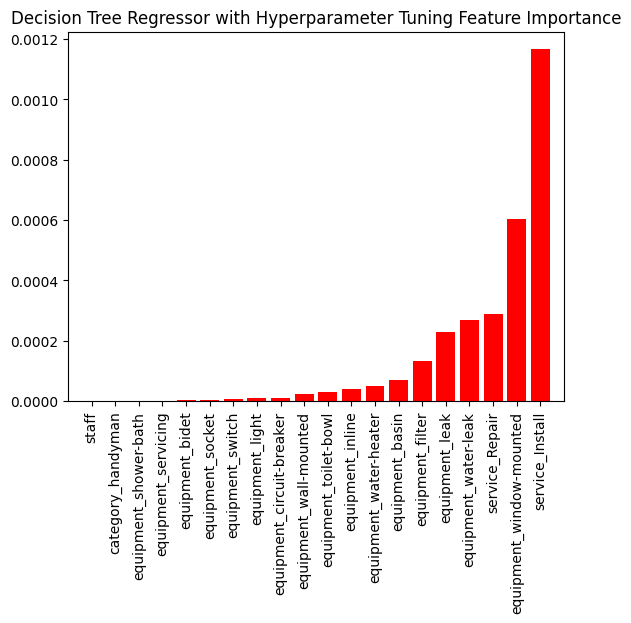

In [20]:
# Feature Importance Visualisation
skplt.estimators.plot_feature_importances(reg_dtr, feature_names = feature_names,
                                         title="Decision Tree Regressor Feature Importance",
                                         x_tick_rotation=90, order="ascending")
skplt.estimators.plot_feature_importances(rscv_dtr.best_estimator_, feature_names = feature_names,
                                         title="Decision Tree Regressor with Hyperparameter Tuning Feature Importance",
                                         x_tick_rotation=90, order="ascending")

##### Advanced Modelling

In [21]:
# Random Forest Regressor
reg_rfr = RandomForestRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_rfr = reg_rfr.predict(X_test_selected)

evaluate(y_test, y_pred_rfr)

Mean Absolute Error (MAE): 9.902402738743598
Mean Squared Error (MSE): 211.4888842641694
Root Mean Squared Error (RMSE): 14.542657400357385
R-squared Coefficient (R^2): 0.9703285125624715


In [22]:
# XG Boost Regressor
reg_xgbr = XGBRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_xgbr = reg_xgbr.predict(X_test_selected)

evaluate(y_test, y_pred_xgbr)

Mean Absolute Error (MAE): 9.898744374690203
Mean Squared Error (MSE): 211.43350985223458
Root Mean Squared Error (RMSE): 14.540753414188503
R-squared Coefficient (R^2): 0.9703362814869415


In [23]:
# LightGBM Regressor
reg_lgbmr = lgb.LGBMRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_lgbmr = reg_lgbmr.predict(X_test_selected)

evaluate(y_test, y_pred_lgbmr)

Mean Absolute Error (MAE): 9.907213442153378
Mean Squared Error (MSE): 211.67175708913888
Root Mean Squared Error (RMSE): 14.548943504225276
R-squared Coefficient (R^2): 0.9703028558536207


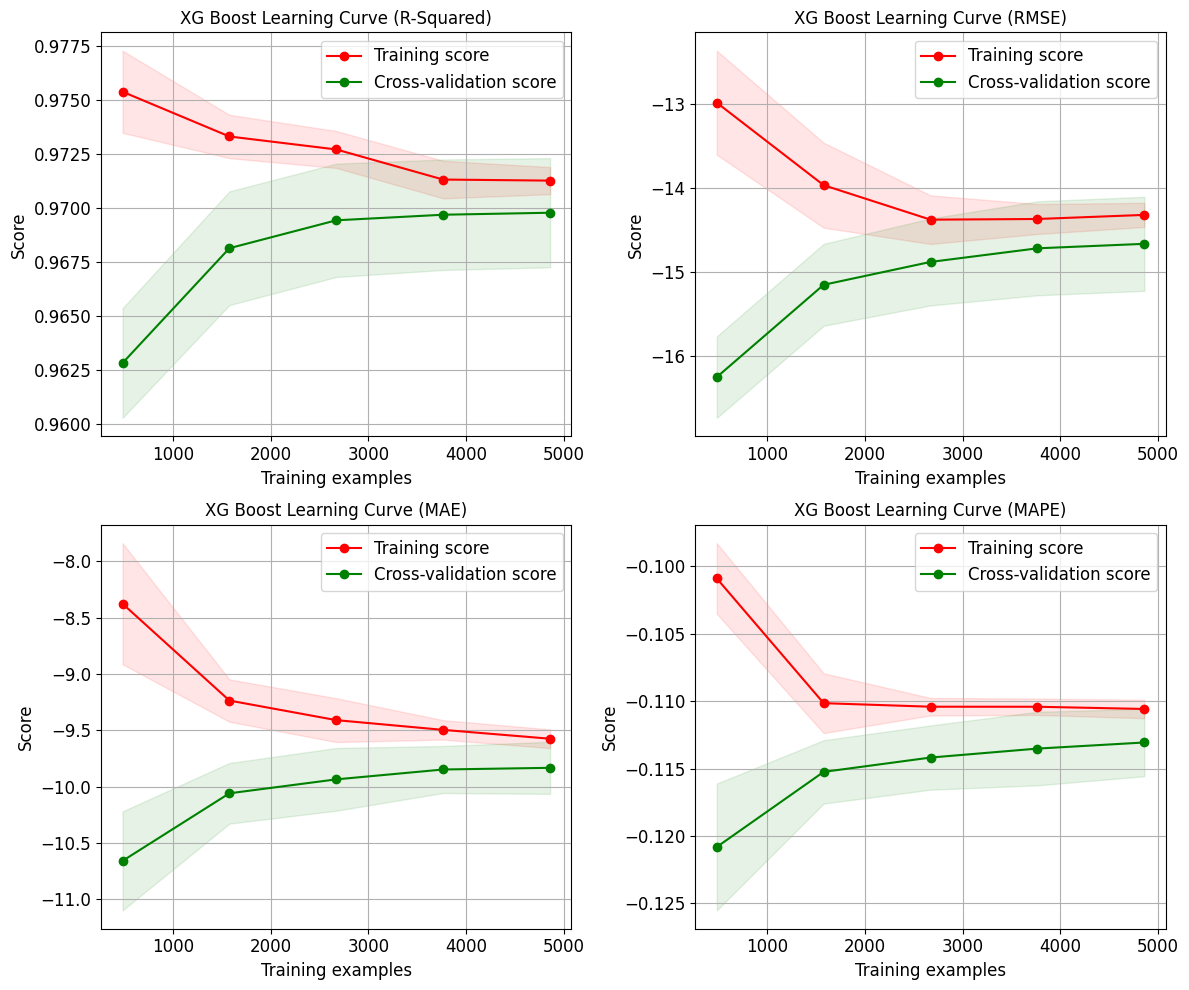

In [24]:
## Cross Validation
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  
ax1, ax2, ax3, ax4 = axes.flatten() 
y_train_reshaped = np.ravel(y_train)

# Learning curves
skplt.estimators.plot_learning_curve(XGBRegressor(random_state=42), X_train_selected, y_train_reshaped,
                                     cv=5, shuffle=True, scoring="r2", n_jobs=-1,
                                     figsize=(6, 4), title_fontsize="large", text_fontsize="large",
                                     title="XG Boost Learning Curve (R-Squared)", ax=ax1)
skplt.estimators.plot_learning_curve(XGBRegressor(random_state=42), X_train_selected, y_train_reshaped,
                                     cv=5, shuffle=True, scoring="neg_root_mean_squared_error", n_jobs=-1,
                                     figsize=(6, 4), title_fontsize="large", text_fontsize="large",
                                     title="XG Boost Learning Curve (RMSE)", ax=ax2)
skplt.estimators.plot_learning_curve(XGBRegressor(random_state=42), X_train_selected, y_train_reshaped,
                                     cv=5, shuffle=True, scoring="neg_mean_absolute_error", n_jobs=-1,
                                     figsize=(6, 4), title_fontsize="large", text_fontsize="large",
                                     title="XG Boost Learning Curve (MAE)", ax=ax3)
skplt.estimators.plot_learning_curve(XGBRegressor(random_state=42), X_train_selected, y_train_reshaped,
                                     cv=5, shuffle=True, scoring="neg_mean_absolute_percentage_error", n_jobs=-1,
                                     figsize=(6, 4), title_fontsize="large", text_fontsize="large",
                                     title="XG Boost Learning Curve (MAPE)", ax=ax4)

plt.tight_layout()
plt.show()

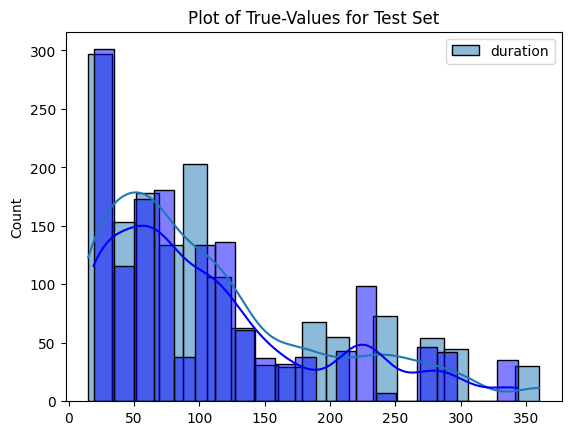

In [25]:
# Plot graph to visualise how far predictions are from true-values for test set
sns.histplot(y_test, label='true', color='red', kde=True)
sns.histplot(y_pred_rfr, label='predicted', color='blue', kde=True)
plt.title("Plot of True-Values for Test Set")
plt.show()

In [30]:
## Hyperparameter Tuning
# Random Forest Model Parameters
reg_rfr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [31]:
# Use Grid Search
y_train_reshaped = np.ravel(y_train)

params = { 
    'max_depth': [5, 10, 12, 15, 17, 20],     
    'min_samples_split': [2, 5, 10, 15, 20, 40], 
    'min_samples_leaf': [1, 3, 5, 7, 10, 20],
    "max_features": [1.0, None],
}

gscv_rfr = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                        param_grid=params, 
                        scoring='neg_root_mean_squared_error', 
                        n_jobs=-1)
gscv_rfr.fit(X_train_selected, y_train_reshaped)

best_params_rfr = gscv_rfr.best_params_
print("Best Parameters For Random Forest:", best_params_rfr)

y_pred_gscv_rfr = gscv_rfr.predict(X_test_selected)

evaluate(y_test, y_pred_gscv_rfr)

Best Parameters For Random Forest: {'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 7, 'min_samples_split': 40}
Mean Absolute Error (MAE): 9.897964774597456
Mean Squared Error (MSE): 211.38157846139515
Root Mean Squared Error (RMSE): 14.538967585815547
R-squared Coefficient (R^2): 0.970343567362113


<Axes: title={'center': 'Random Forest Regressor with Hyperparameter Tuning Feature Importance'}>

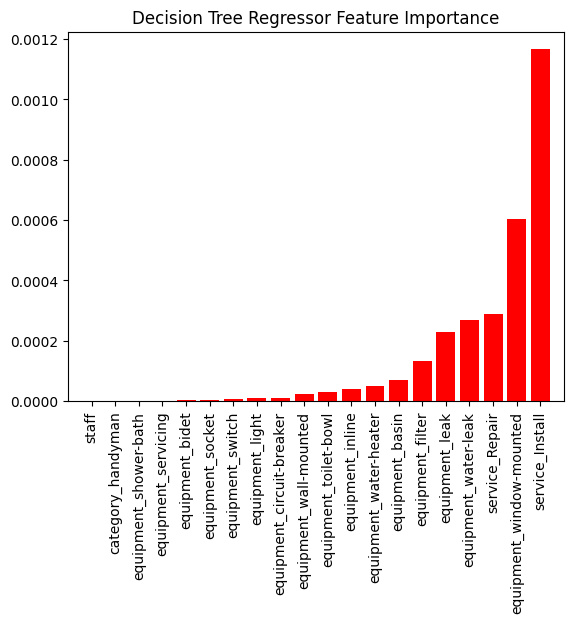

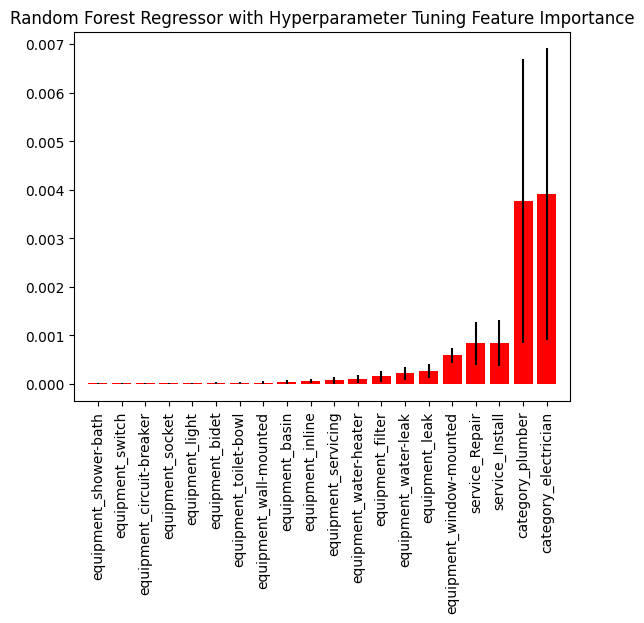

In [34]:
## Feature Evaluation
# Feature Importance Visualisation
skplt.estimators.plot_feature_importances(rscv_dtr.best_estimator_, feature_names = feature_names,
                                         title="Decision Tree Regressor Feature Importance",
                                         x_tick_rotation=90, order="ascending")
skplt.estimators.plot_feature_importances(gscv_rfr.best_estimator_, feature_names = feature_names,
                                         title="Random Forest Regressor with Hyperparameter Tuning Feature Importance",
                                         x_tick_rotation=90, order="ascending")

In [35]:
# Dump Model Into Pickle
pickle.dump(rscv_dtr, open('../public/analytics/advanced/job-duration-model.pkl', 'wb'))

### Modelling Service Price Prediction